In [1]:
import torch
from torch import nn # it means that importing an neural network librar
from torch.utils.data import DataLoader #helps in creating the batches
'''
Gradient descent = All the datapoints - compute output - compute loss - gradient descent
Stochastic Gradient Descent - Single datapoint - compute output - compute loss
            - gradient descent - next data point
Mini batch Gradient Descent - create bathes of data - compute output foe each batch -
          - gradinet descent - next batch
'''
from torchvision import datasets #download the dataset
from torchvision.transforms import ToTensor # is used to convert the input to torch tensor format
import matplotlib.pyplot as plt
import torch.nn.functional as F

## download the dataset

In [2]:
training_data = datasets.FashionMNIST(root = "data",train = True,download = True,transform = ToTensor())
testing_data = datasets.FashionMNIST(root = "data",train = False,download = True,transform = ToTensor())

100%|██████████| 26421880/26421880 [00:02<00:00, 10399578.93it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 175810.29it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3169376.29it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8671597.19it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
len(training_data)

60000

In [4]:
torch.randint(len(training_data),size=(1,)).item()

29545

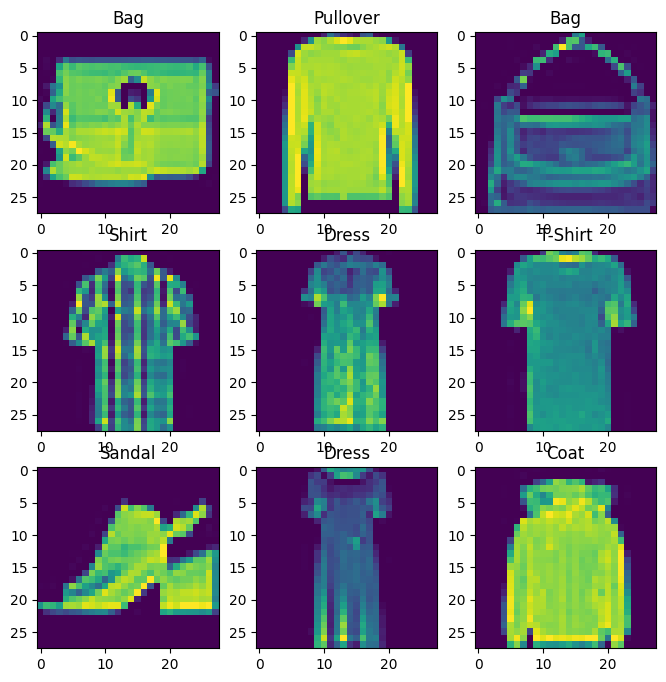

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8,8))

cols, rows = 3,3

for i in range(1,rows*cols+1):
  sample_idx = torch.randint(len(training_data),size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows,cols,i)
  plt.title(labels_map[label])
  plt.imshow(img.squeeze())

## Batching

In [6]:
batch_size = 64

train_dataloader = DataLoader(training_data,batch_size=batch_size)
test_dataloader = DataLoader(testing_data,batch_size=batch_size)

## Model Creation

In [7]:
class NeuralNetwork(nn.Module): #

  def __init__(self):
    super(NeuralNetwork,self).__init__()

    ## Init function is used to define the architecture blocks
    self.flatten = nn.Flatten() # 28 x 28 x1 - 764 x 1 vectpor
    self.layer1 = nn.Linear(28*28,512)
    self.layer2 = nn.Linear(512,256)
    self.layer3 = nn.Linear(256,10)

  def forward(self,x):
    x = self.flatten(x)
    x = self.layer1(x)
    x = F.relu(x) #F.sigmoid()
    x = self.layer2(x)
    x = F.sigmoid(x)
    x = self.layer3(x)
    return x

In [8]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

In [36]:
model = NeuralNetwork()
model.to(device)
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=784, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=10, bias=True)
)

In [37]:
## loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 1e-2)

In [38]:
def training_loop(dataloader,model,loss_fn,optimizer):
  model.train()

  #pass every batch of data to the model
  for batch, (X,y) in enumerate(dataloader):
    X = X.to(device)
    y = y.to(device)

    pred = model(X)
    loss = loss_fn(pred,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if batch % 100 == 0:
      print (f'loss : {loss.item()}')

In [39]:
## testing the model
def testing_loop(dataloader,model,loss_fn):
  model.eval()
  test_loss = 0
  correct = 0
  for X,y in dataloader:
    X = X.to(device)
    y = y.to(device)

    pred = model(X)
    # print (pred.shape)
    # print (pred)
    # print (pred.argmax(1))
    # print (y)
    # print (pred.argmax(1) == y)
    # print ((pred.argmax(1) == y).type(torch.float))
    # print ((pred.argmax(1) == y).type(torch.float).sum()
    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss += loss_fn(pred,y).item()
  test_loss = test_loss/len(dataloader)
  print (len(dataloader.dataset))
  accuracy = (correct/len(dataloader.dataset))*100
  print (f'Accuracy : {accuracy} with test error {test_loss}')

In [40]:
epochs = 5 #how many times you have to send data to the model

for t in range(epochs):
  training_loop(train_dataloader,model,loss_fn,optimizer)
  testing_loop(test_dataloader,model,loss_fn)
  print(f' ==================== EPOCH : {t} ============================')

loss : 2.429187536239624
loss : 2.29122257232666
loss : 2.2718727588653564
loss : 2.255263090133667
loss : 2.1867990493774414
loss : 2.164750337600708
loss : 2.0828697681427
loss : 1.9638186693191528
loss : 1.84017014503479
loss : 1.716002345085144
10000
Accuracy : 54.72 with test error 1.6791270113295051
 ==================== EPOCH : 0 ============================
loss : 1.7191139459609985
loss : 1.613051414489746
loss : 1.4541351795196533
loss : 1.4599449634552002
loss : 1.2896888256072998
loss : 1.3212265968322754
loss : 1.2589086294174194
loss : 1.181429386138916
loss : 1.202329397201538
loss : 1.1422268152236938
10000
Accuracy : 63.44 with test error 1.1105406838617506
 ==================== EPOCH : 1 ============================
loss : 1.1773593425750732
loss : 1.1327946186065674
loss : 0.9746478199958801
loss : 1.097007155418396
loss : 0.9562776684761047
loss : 1.0152134895324707
loss : 1.0132367610931396
loss : 0.932159423828125
loss : 0.9622572064399719
loss : 0.940130293369293

In [ ]:
##saving the model